In [1]:
#Reads the MURA dir structure,for every patient, every study under it,computes the total 
#views/images and extracts the label from the study label.
#Also computes patient study count for visualizing the data in the next section.
import os
import pandas as pd
from tqdm import tqdm

data_cat = ['train', 'valid'] # data categories

def get_path_imgCount_label(study_type):
    
    study_label = {'positive': 1, 'negative': 0}
    study_data = {}
    patientStudyCount={}
    for phase in data_cat:
        BASE_DIR = './MURA-v1.1/%s/%s/' % (phase, study_type)
        patients = list(os.walk(BASE_DIR))[0][1] # list of patient folder names
        #print("patients={}".format(patients))
        study_data[phase] = pd.DataFrame(columns=['Path', 'Count', 'Label'])
        patientStudyCount[phase] = pd.DataFrame(columns=['StudyCount'])
        #print("study_data=".format(study_data))
        i = 0;j=0
        
        for patient in tqdm(patients): # for each patient folder
            patientStudyCount[phase].loc[j]=[len(os.listdir(BASE_DIR + patient))]
            #print("patient={}, study_count={}".format(patient,patientStudyCount))
            for study in os.listdir(BASE_DIR + patient): # for each study in that patient folder
                #print("study={}".format(study))
                label = study_label[study.split('_')[1]] # get label 0 or 1,based on folder name.
                path = BASE_DIR + patient + '/' + study + '/' # path to this study
                #print("label={} path={}".format(label,path))
                study_data[phase].loc[i] = [path, len(os.listdir(path)), label] # add new row
               
                #print("study_data={}".format(study_data))
                i+=1
            j+=1
    #print("study_data={}".format(study_data))
    return study_data,patientStudyCount

100%|███████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 228.37it/s]


# of study_data for phase train =3460
study group category=Counter({1: 3094, 2: 157, 3: 12, 4: 4})


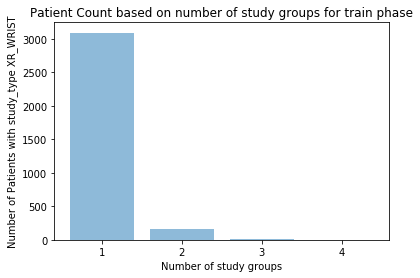

# of study_data for phase valid =237
study group category=Counter({1: 182, 2: 21, 3: 3, 4: 1})


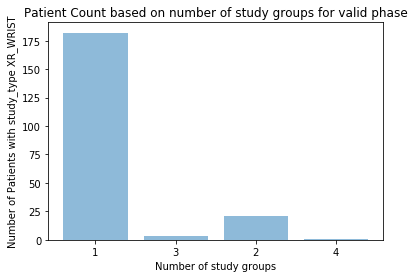

In [2]:
#Exploratory Data analysis.
#Plots the number of patients having 1,2,3,4 study groups for both valid and train phase.
#The study_data object has number of views per study groups.
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

study_data,patientStudyCount=get_path_imgCount_label('XR_WRIST')

my_dict={}
for phase in data_cat:
    print("# of study_data for phase {} ={}".format(phase,len(study_data[phase])))
    my_dict[phase]=pd.DataFrame(columns=['view_key','patient_count'])
    my_dict[phase]=Counter(patientStudyCount[phase].StudyCount)
    print("study group category={}".format(my_dict[phase]))
    x_pos = np.arange(1,len(my_dict[phase].keys())+1)
    #print('x_pos={}'.format(x_pos))
    plt.bar(x_pos,my_dict[phase].values(), align='center', alpha=0.5)
    plt.xticks(x_pos, my_dict[phase].keys() )
    plt.xlabel('Number of study groups')
    plt.ylabel('Number of Patients with study_type %s' %'XR_WRIST')
    plt.title('Patient Count based on number of study groups for %s phase' %phase)
    plt.show()


In [3]:
origin_study_data=study_data.copy()
#As my GPU goes OOM after 400 records,limit training to 400 records.
study_data["train"]=study_data["train"][0:400]
#study_data["valid"]=study_data["valid"][0:20]
for phase in data_cat:
    print("# of study_data for phase {} ={}".format(phase,len(study_data[phase])))
#print("study_data for phase valid ={}".format(study_data['valid']))

# of study_data for phase train =400
# of study_data for phase valid =237


In [4]:
#Ref:https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
#Ref: https://www.aiworkbox.com/lessons/turn-a-list-of-pytorch-tensors-into-one-tensor
#defines a dataset, for every study group of a patient,gets the path, view or study counts and label.
#Applies transformation if any and converts a list of images (tensors) into one, using the stack function.
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.datasets.folder import pil_loader
import torch

class MuraDataset(Dataset):
   
    def __init__(self, df, transform=None):
        #Args:
            #df : A pandas DataFrame with image path,counts and labels.
            #transform (callable, optional): Optional transform to be applied
                #on a sample.
                
        self.df = df
        self.transform = transform
        #self.imageShow=False

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx): #for a studygroup of a patient, get the image paths,counts and the label.
        study_path = self.df.iloc[idx, 0]
        count = self.df.iloc[idx, 1]
        labels = self.df.iloc[idx, 2]
        images = []
        for i in range(count):
            image = pil_loader(study_path + 'image%s.png' % (i+1))
            images.append(self.transform(image))
            #plt.imshow(image)
            #plt.show()
            #print("Size: {} ".format(np.array(image).shape))
        images = torch.stack(images)
        sample = {'images': images, 'label': labels}
        
        return sample

In [5]:
#Ref: https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
#Dataloaders are iterators thro the dataset , which helps in bacthing,shuffling and parallel process 
#using mutli workers(4).

#From the MURA paper
#"Before feeding images into the network, we normalized each image to have the same mean and standard deviation
#of images in the ImageNet training set. We then scaled the variable-sized images to 224×224.
#We augmented the data during training by applying random lateral inversions and rotations."

#define muraDataLoaders or iterators to iterate through the muraDataset and apply needed transforms.
#could not have a batch size of more than 1. Since I had only one GPU, was throwing exception if num_workers >0
#So no parallelism was achieved.
import pprint
def muraDataLoaders(study_data, batch_size=1):

    mura_transforms = {
        'train': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#normalize to imageNet mean &std.
        ]),
        'valid': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    image_datasets = {phase: MuraDataset(study_data[phase], transform=mura_transforms[phase]) for phase in data_cat}
    pprint.pformat("image_datasets={}".format(image_datasets)) 
    dataloaders = {phase: DataLoader(image_datasets[phase], batch_size=batch_size, shuffle=True, num_workers=0) for phase in data_cat}
    return dataloaders

In [6]:
#Ref:https://pytorch.org/docs/master/_modules/torchvision/models/densenet.html
#source below from above URL for denseNet169 and denseNet.
#Need to move it to its own .py file.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from collections import OrderedDict

__all__ = ['DenseNet', 'densenet169']


model_urls = {
    'densenet169': 'https://download.pytorch.org/models/densenet169-b2777c0a.pth',
}

def densenet169(pretrained=False, **kwargs):
    r"""Densenet-169 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = DenseNet(num_init_features=64, growth_rate=32, block_config=(6, 12, 32, 32),
                     **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['densenet169']), strict=False)
    return model

class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                        growth_rate, kernel_size=1, stride=1, bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                        kernel_size=3, stride=1, padding=1, bias=False)),
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
    """
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000):

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))
        
        # Linear layer
        # self.classifier = nn.Linear(num_features, 1000)
        # self.fc = nn.Linear(1000, 1)
        
        self.fc = nn.Linear(num_features, 1)
        
        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal(m.weight.data)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.avg_pool2d(out, kernel_size=7, stride=1).view(features.size(0), -1)
        # out = F.relu(self.classifier(out))
        out = F.sigmoid(self.fc(out))
        return out
    

In [7]:
model = densenet169(pretrained=True)
model = model.cuda()#train on GPU if available.

c:\users\sp2624\appdata\local\continuum\miniconda3\envs\capstone-project\lib\site-packages\ipykernel_launcher.py:118: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [8]:
#compute the balanced class weights for weighted binary cross entrophy.
#fucntion classCount gives the number of positive and negative counts per phase       
# return a count of positive or negative image class to assign wts.
def classCount(dframe,result): 
    #count=dframe[dframe['Label']==result]['Count'].sum()
    count=dframe[dframe['Path'].str.contains(result)]['Count'].sum()
    return count

positive_count={phase: classCount(study_data[phase],'positive') for phase in data_cat}
negative_count={phase: classCount(study_data[phase],'negative') for phase in data_cat}

print("poitive_count={} , negative_count={}".format(positive_count,negative_count))
    

poitive_count={'train': 481, 'valid': 295} , negative_count={'train': 662, 'valid': 364}


In [9]:
from torch.autograd import Variable
def numpyToVariable(x):
    #convert numpy float to Variable tensor float    
    return Variable(torch.cuda.FloatTensor([x]), requires_grad=False)

zero_weight= {phase: numpyToVariable(positive_count[phase] / (negative_count[phase] + positive_count[phase])) for phase in data_cat}
one_weight = {phase: numpyToVariable(negative_count[phase] / (negative_count[phase] + positive_count[phase])) for phase in data_cat}
print("zero_weight={} , one_weight={}".format(zero_weight,one_weight))


zero_weight={'train': tensor([0.4208], device='cuda:0'), 'valid': tensor([0.4476], device='cuda:0')} , one_weight={'train': tensor([0.5792], device='cuda:0'), 'valid': tensor([0.5524], device='cuda:0')}


In [10]:
# weighted BCE is given by −(wt1*y*log(p)+wt0*(1−y)log(1−p))

class Weighted_BCE_loss(torch.nn.modules.Module):
    def __init__(self, Wt1, Wt0):
        super(Weighted_BCE_loss, self).__init__()
        self.Wt1 = Wt1
        self.Wt0 = Wt0
        
    def forward(self, inputs, targets, phase):
        loss = - (self.Wt1[phase] * targets * inputs.log() + self.Wt0[phase] * (1 - targets) * (1 - inputs).log())
        return loss
    

Train batches: 400
Valid batches: 237 

Epoch 1/5
----------
================Phase=train


c:\users\sp2624\appdata\local\continuum\miniconda3\envs\capstone-project\lib\site-packages\torch\nn\functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train Loss: 0.3343 Acc: 0.5775
Confusion Meter:
 [[0.6652893  0.33471075]
 [0.556962   0.443038  ]]
================Phase=valid
valid Loss: 0.4559 Acc: 0.4937
Confusion Meter:
 [[0.44285715 0.55714285]
 [0.4329897  0.5670103 ]]
Time elapsed: 3m 58s

Epoch 2/5
----------
================Phase=train
train Loss: 0.3206 Acc: 0.6225
Confusion Meter:
 [[0.6735537 0.3264463]
 [0.4556962 0.5443038]]
================Phase=valid
valid Loss: 0.5375 Acc: 0.4473
Confusion Meter:
 [[0.40714285 0.5928571 ]
 [0.49484536 0.5051546 ]]
Time elapsed: 7m 50s

Epoch 3/5
----------
================Phase=train
train Loss: 0.3075 Acc: 0.6600
Confusion Meter:
 [[0.6859504  0.3140496 ]
 [0.37974682 0.62025315]]
================Phase=valid
valid Loss: 0.6573 Acc: 0.5359
Confusion Meter:
 [[0.76428574 0.23571429]
 [0.7938144  0.20618556]]
Epoch     2: reducing learning rate of group 0 to 1.0000e-05.
Time elapsed: 11m 42s

Epoch 4/5
----------
================Phase=train
train Loss: 0.2912 Acc: 0.7125
Confusion Met

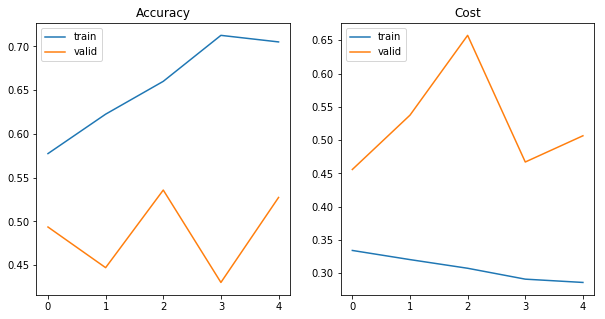

no of abnormal labels=67 , normal labels=133
no of abnormal preds=8, no of normal preds=105
running_correct =113
observed_acc=0.565
Loss: 1.5998,obsv_Acc: 0.565,exp_Acc: 0.3625,kappa: 0.3176
Confusion Meter:
 [[0.7894737  0.21052632]
 [0.880597   0.11940298]]


In [11]:
#import from train.py the train_model and predict_with_metrics 
#criterion or loss function is the weighted BCE agve
#Using Adam as the optimizer with the learning rate of 0.0001
#Using a scheduler to reduce the learning rate on a plateau.

from train import train_model, predict_with_metrics
if __name__ == '__main__':
    dataloaders = muraDataLoaders(study_data, batch_size=1)

    criterion = Weighted_BCE_loss(one_weight, zero_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, verbose=True)
    df_size = {phase: len(study_data[phase]) for phase in data_cat}
    
    #Train model
    model = train_model(model, criterion, optimizer, dataloaders, scheduler, df_size, num_epochs=5)
    #Save the weights
    torch.save(model.state_dict(), 'models/model.pth')
    
    #Since the predict_with_metrics works on valid data, we assign the new valid data
    # to be origin study_data from 400-600.This is considered the testing data.
    study_data['valid']=origin_study_data['train'][400:600]
    
    test_df_size= {phase: len(study_data[phase]) for phase in data_cat}
    test_dataloaders = muraDataLoaders(study_data, batch_size=1)
    
    predict_with_metrics(model, criterion, test_dataloaders, test_df_size)